# Videos recording-times analysis

This notebook summarizes the recordings dates and times of tens of few-minute-videos of Ayalon Road.
It can be seen that **the videos reasonably cover all the days of the week during the hours 9:00-20:00**.

The videos were taken by the camera of a Galaxy S8+ in Hyperlapse mode with x8 speed, FHD resolution and standard configuration elsewise.
It turns out that such a video of 8 minutes (compressed into 1 minute) requires ~120MB of storage (or equivalently 100 videos = 13 hours = 12GB).

The simple recording-system-layout is shown below, also demonstrating some unfortunate glass-reflection issues which somewhat damage the data.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import seaborn as sns
import re
from pathlib import Path
import pickle as pkl
from time import time
from datetime import datetime
from tqdm import tqdm, tnrange, tqdm_notebook
from pprint import pprint
import os, sys
from warnings import warn
import itertools
from collections import Counter
import cv2
from PIL import Image

In [3]:
mpl.rcParams.update({'font.size': 13})

## Recording layout

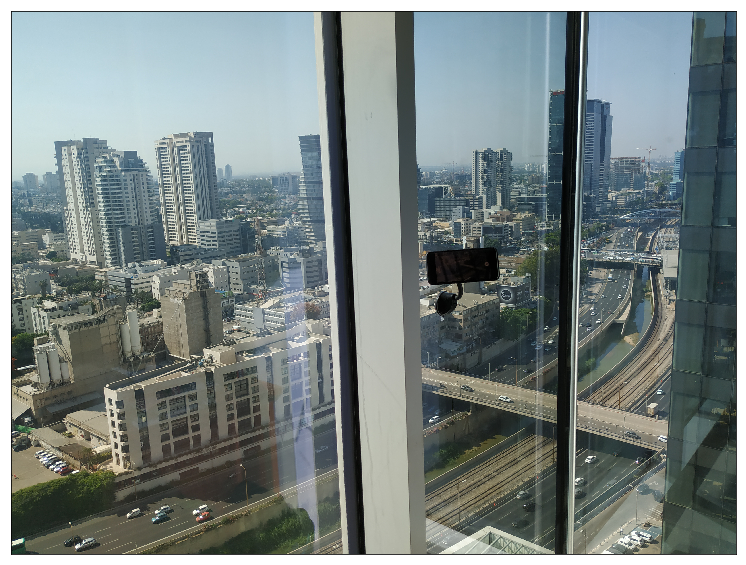

In [4]:
plt.figure(figsize=(16,10))
plt.imshow(np.asarray(Image.open('../Outputs/Videos data/Photography layout/stand2.jpg')))
plt.xticks(())
plt.yticks(());

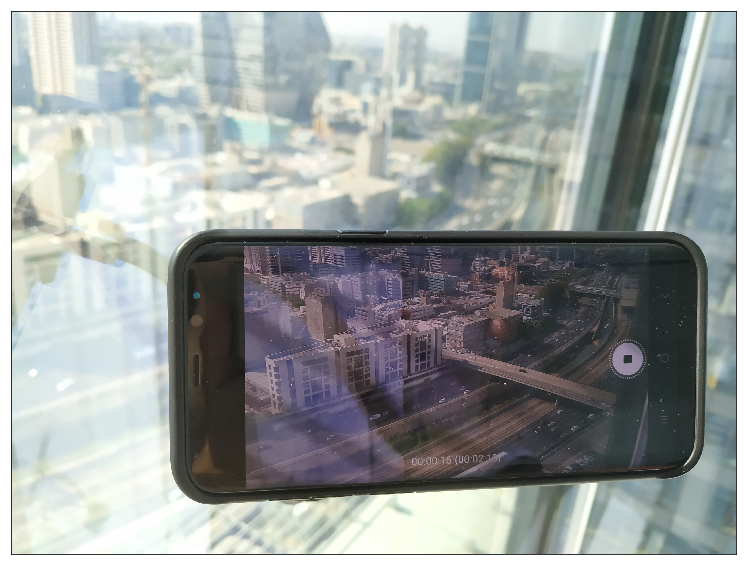

In [5]:
plt.figure(figsize=(16,10))
plt.imshow(np.asarray(Image.open('../Outputs/Videos data/Photography layout/close_up.jpg')))
plt.xticks(())
plt.yticks(());

## Load data and check videos lengths

In [6]:
DATA = Path(r'd:\media\videos\ayalon')
files = [f for f in os.listdir(DATA) if f.endswith('.mp4')]
print('Number of videos:', len(files))
print(files[:3])
print(files[-3:])

Number of videos: 81
['20190520_105429.mp4', '20190520_112342.mp4', '20190520_141707.mp4']
['20190705_101321.mp4', '20190706_005745.mp4', '20190712_230316.mp4']


81 videos X 10 minutes per video = 13.8 hours
81 videos X 163 MB per video = 13.2 GB


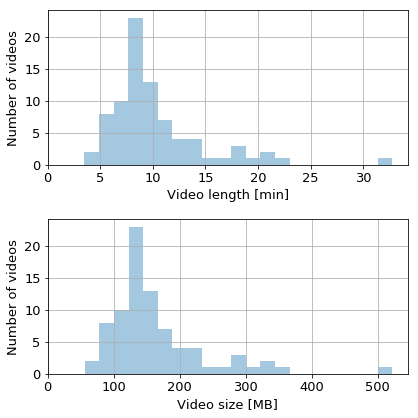

In [7]:
FPS = 30/8
lengths = [cv2.VideoCapture(str(DATA/file)).get(cv2.CAP_PROP_FRAME_COUNT) / (60*FPS) for file in files]
print(f'{len(lengths):d} videos X {np.mean(lengths):.0f} minutes per video = {np.sum(lengths)/60:.1f} hours')

sizes_mb = [os.path.getsize(DATA/f)/1e6 for f in files]
print(f'{len(sizes_mb):d} videos X {np.mean(sizes_mb):.0f} MB per video = {np.sum(sizes_mb)/1e3:.1f} GB')

_, axs = plt.subplots(2,1, figsize=(6,6))

ax = axs[0]
sns.distplot(lengths, kde=False, ax=ax)
ax.set_xlim((0,None))
ax.set_xlabel('Video length [min]')
ax.set_ylabel('Number of videos')
ax.grid()

ax = axs[1]
sns.distplot(sizes_mb, kde=False, ax=ax)
ax.set_xlim((0,None))
ax.set_xlabel('Video size [MB]')
ax.set_ylabel('Number of videos')
ax.grid()

plt.tight_layout()

## Check videos cover of days and times

In [8]:
dt = [datetime(int(f[:4]),int(f[4:6]),int(f[6:8]),int(f[9:11]),int(f[11:13]),int(f[13:15])) for f in files]
weekdays = [(d.weekday() + 1) % 7 + 1 for d in dt] # Hebrew format, i.e. 1 = Sunday, 7 = Saturday

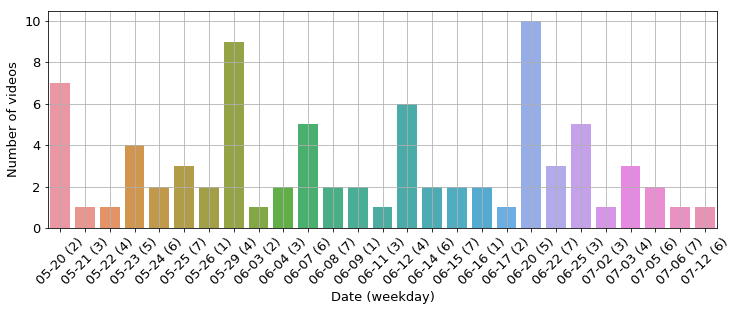

In [9]:
count = Counter([d.strftime(f'%m-%d ({wd:d})') for d,wd in zip(dt,weekdays)])

plt.figure(figsize=(12,4))
sns.barplot(x=list(count.keys()), y=list(count.values()))
plt.xlabel('Date (weekday)')
plt.ylabel('Number of videos')
plt.grid()
plt.xticks(rotation=45);

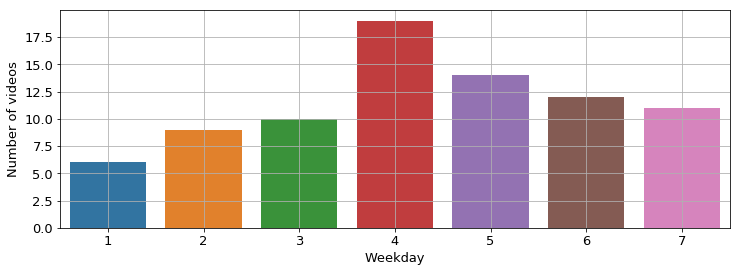

In [10]:
count = Counter(weekdays)

plt.figure(figsize=(12,4))
sns.barplot(x=list(count.keys()), y=list(count.values()))
plt.xlabel('Weekday')
plt.ylabel('Number of videos')
plt.grid()

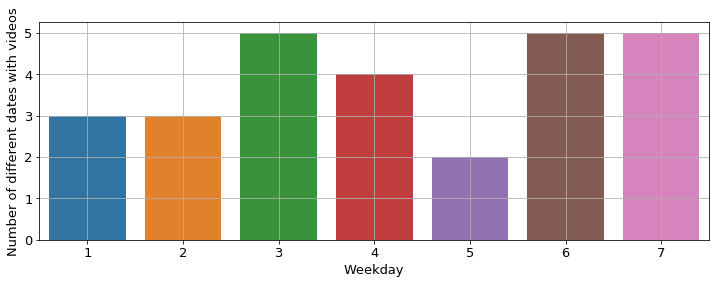

In [11]:
count = Counter([(d.weekday() + 1) % 7 + 1 for d in np.unique([d.date() for d in dt])])

plt.figure(figsize=(12,4))
sns.barplot(x=list(count.keys()), y=list(count.values()))
plt.xlabel('Weekday')
plt.ylabel('Number of different dates with videos')
plt.grid()

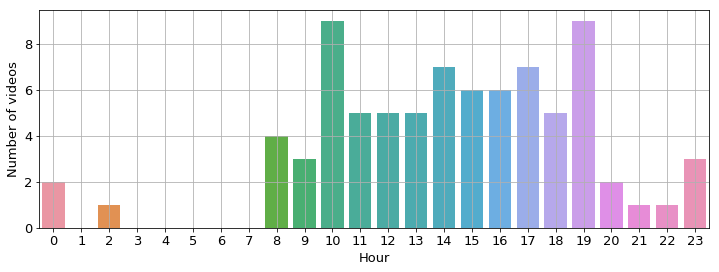

In [12]:
count = Counter([d.hour for d in dt])
count = {h: (count[h] if h in count else 0) for h in list(range(6,24))+list(range(0,6))}

plt.figure(figsize=(12,4))
sns.barplot(x=list(count.keys()), y=list(count.values()))
plt.xlabel('Hour')
plt.ylabel('Number of videos')
plt.grid()

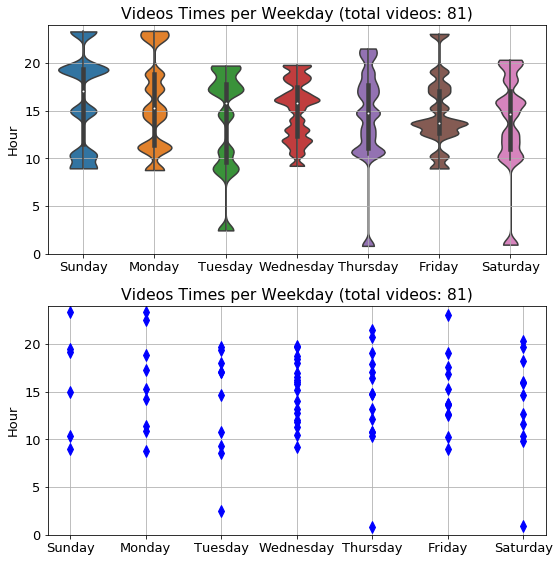

In [13]:
times = [d.hour+d.minute/60+d.second/3600 for d in dt]

_, axs = plt.subplots(2,1, figsize=(8,8))

ax = axs[0]
sns.violinplot(x = weekdays, y = times, cut=0, bw=0.1, ax=ax)
ax.set_xticklabels(('Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'))
#ax.set_xlabel('Weekday')
ax.set_ylabel('Hour')
ax.set_ylim((0,24))
ax.set_title(f'Videos Times per Weekday (total videos: {len(times):d})')
ax.grid()

ax = axs[1]
ax.plot(weekdays, times, 'bd', markersize=8)
ax.set_xticks(np.arange(1,8))
ax.set_xticklabels(('Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'))
#ax.set_xlabel('Weekday')
ax.set_ylabel('Hour')
ax.set_ylim((0,24))
ax.set_title(f'Videos Times per Weekday (total videos: {len(times):d})')
ax.grid()

plt.tight_layout()

## Save all metadata

In [38]:
df = pd.DataFrame({'video':files, 'size_mb':sizes_mb, 'len_minutes':lengths,
                   'date':[d.strftime('%Y%m%d') for d in dt], 'time':[d.hour+d.minute/60+d.second/3600 for d in dt],
                   'weekday': weekdays}, index=files)
df.to_csv('videos_metadata.csv')
df

,video,size_mb,len_minutes,date,time,weekday
20190520_105429.mp4,20190520_105429.mp4,115.474790,7.231111,20190520,10.908056,2
20190520_112342.mp4,20190520_112342.mp4,522.146511,32.755556,20190520,11.395000,2
20190520_141707.mp4,20190520_141707.mp4,129.201198,8.102222,20190520,14.285278,2
20190520_151643.mp4,20190520_151643.mp4,134.681172,8.435556,20190520,15.278611,2
20190520_171559.mp4,20190520_171559.mp4,166.763672,10.453333,20190520,17.266389,2
20190520_185004.mp4,20190520_185004.mp4,232.324197,14.564444,20190520,18.834444,2
20190520_232200.mp4,20190520_232200.mp4,200.517861,12.577778,20190520,23.366667,2
20190521_192033.mp4,20190521_192033.mp4,227.259598,14.257778,20190521,19.342500,3
20190522_194812.mp4,20190522_194812.mp4,127.687294,8.004444,20190522,19.803333,4
20190523_005006.mp4,20190523_005006.mp4,138.442708,8.680000,20190523,0.835000,5
